In [1]:
import matplotlib, shutil
shutil.rmtree(matplotlib.get_cachedir(), ignore_errors=True)
print("cache cleared:", matplotlib.get_cachedir())


cache cleared: /home/dongyl/.cache/matplotlib


In [12]:
from matplotlib import font_manager as fm
print(fm.findfont("Helvetica"))


/home/dongyl/anaconda3/envs/geocat/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf


In [14]:
import numpy as np
import xarray as xr
from scipy import stats
from scipy import optimize
from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import copy
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression
import dyl_function_slope as dyl
import areamean_dhq as dhq
import cmaps
import matplotlib as mpl
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = [ 'Helvetica']#,"Arial", "DejaVu Sans"]

#plt.rcParams['font.family'] = 'Helvetica'
ccmap = cmaps.ncl_default

# 定义计算区域平均的函数

In [4]:
##########南半球40:56，北半球89:105############
def areamean_func_3D(ndarray,slice,lat_ds):
    time_label, lat_label,lon_label = ndarray.shape
    nrows = lat_label
    latsr = np.deg2rad(lat_ds['lat'].values[slice]).reshape((nrows, 1))
    #weight_matrix = np.repeat(np.cos(latsr), 1, axis=1)
    ds_w = ndarray * np.cos(latsr)
    weight_sum = copy.deepcopy(np.cos(latsr))
    #weight_sum[ds_w[0, 0, 0].isnull().data] = np.nan
    obs_mean_areamean = ds_w.sum(1) / np.nansum(weight_sum)
    return obs_mean_areamean

def areamean_func_4D(ndarray,slice,lat_ds):
    months_label, time_label, lat_label,lon_label = ndarray.shape
    nrows = lat_label
    latsr = np.deg2rad(lat_ds['lat'].values[slice]).reshape((nrows, 1))
    weight_matrix = np.repeat(np.cos(latsr), lon_label, axis=1)
    ds_w = ndarray * weight_matrix
    weight_sum = copy.deepcopy(weight_matrix)
    #weight_sum[ds_w[0, 0, 0].isnull().data] = np.nan
    obs_mean_areamean = ds_w.sum(dim=['lat','lon']) / np.nansum(weight_sum)
    return obs_mean_areamean
def areamean_func_3D(ndarray,slice,lat_ds):
    time_label, lat_label,lon_label = ndarray.shape
    nrows = lat_label
    latsr = np.deg2rad(lat_ds['lat'].values[slice]).reshape((nrows, 1))
    #weight_matrix = np.repeat(np.cos(latsr), 1, axis=1)
    ds_w = ndarray * np.cos(latsr)
    weight_sum = copy.deepcopy(np.cos(latsr))
    #weight_sum[ds_w[0, 0, 0].isnull().data] = np.nan
    obs_mean_areamean = ds_w.sum(1) / np.nansum(weight_sum)
    return obs_mean_areamean

# 定义计算VST转换的函数

In [5]:
Rv = 461.5  # Gas constant for water vapor
Lv = 2.5e6  # Latent heat of vaporization
def calculate_beta(T, delta_T, p):
    # T_fine = interpolate_to_fine(T, p, p_fine)
    # delta_T_fine = interpolate_to_fine(delta_T, p, p_fine)
    # Calculate es, dT_dp, and dT_des as before
    dT_dp = np.gradient(T, p, axis=0)

    # Calculate beta for each time, level, and latitude
    def func(beta, delta_T, dT_dp, T, level):
        # p_adjusted = np.tile(p_fine, (181, 1)).T
        return delta_T - (beta - 1) * (p[level] * dT_dp - Rv * T ** 2 / Lv)

    # Solve for beta
    beta_init = 1.15
    beta = np.empty_like(T)
    for lat in range(T.shape[1]):
        # for level in range(p.size):
        beta[:, lat] = optimize.newton(func, beta_init, args=(delta_T[lat], dT_dp[5, lat], T[5, lat], 5))
    # Return the calculated beta array
    return beta


def calculate_transformed_u(u, beta, p):
    # Calculate u_prime as before using interpolated u and beta
    # Calculate transformed u'
    u_prime = np.empty_like(u)
    for lat in range(u.shape[1]):
        # for level in range(p.size):
        transformed_p = beta[:, lat] * p
        u_prime[::-1, lat] = np.interp(transformed_p[::-1], p[::-1], u[::-1, lat])
    # Return the calculated u_prime array
    return u_prime


# 计算纬向风垂向切面图的数据

In [6]:
#########################以下：计算meri 图数据#############################
ERA5 = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/ua/ERA5_u_1958-2020_288x145_19levels_zonmean.nc').u[22:63,::-1,:,0]
JRA55 = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/ua/JRA55_u_1958-2022_288x145_19levels_zonmean.nc').UGRD_GDS0_ISBL_S123[22:63,::-1,:,0]
MERRA2 = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/ua/u_MERRA2_1980-2022_zonmean_288x145_19levels_yearmean.nc').U[:41,:,:,0]

era5_trend, era5_p_values = dyl.get_slope_p_3D(ERA5)
jra55_trend, jra55_p_values = dyl.get_slope_p_3D(JRA55)
merra2_trend, merra2_p_values = dyl.get_slope_p_3D(MERRA2)

obs_data = [ERA5,MERRA2,JRA55]
trend = [era5_trend,merra2_trend,jra55_trend]
p_values = [era5_p_values,merra2_p_values,jra55_p_values]
obs_clim = [np.nanmean(ERA5,axis=0),np.nanmean(MERRA2,axis=0),np.nanmean(JRA55,axis=0)]
mask_obs_trend = p_values[0] < 0.05
significant_points_ERA5= np.where(mask_obs_trend, True, False)
mask_obs_trend = p_values[1] < 0.05
significant_points_MERRA2= np.where(mask_obs_trend, True, False)
mask_obs_trend = p_values[2] < 0.05
significant_points_JRA55= np.where(mask_obs_trend, True, False)

#h_ssp585 = xr.open_dataset(r'/home/dongyl/Databank/h+ssp585/zonmean/ua_h+ssp585_all_models_1958-2022_zonmean.nc').ua[:,22:63,:,:,0]
#h_ssp585 = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_197901-202212_289x145_zonmean.nc').ua[:,12:504,:,:,0]
h_ssp585 = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_1979-2099_zonmean.nc').ua[:,1:42,:,:,0]

h_ssp585_clim = np.nanmean(np.nanmean(h_ssp585,0),0)
h_ssp585_slope=np.zeros((h_ssp585.shape[0],h_ssp585.shape[2],h_ssp585.shape[3]))
h_ssp585_p_value=np.zeros((h_ssp585.shape[0],h_ssp585.shape[2],h_ssp585.shape[3]))
for model in range(h_ssp585.shape[0]):
    h_ssp585_slope[model], h_ssp585_p_value[model] = dyl.get_slope_p_3D(h_ssp585[model])
h_ssp585_slope_mme = np.nanmean(h_ssp585_slope,0)

threshold = 0.8  # 80% condition
n_models = h_ssp585_slope.shape[0]  # Total number of models (28)
mean_sign = np.sign(h_ssp585_slope_mme)  # Shape: (19, 145)
model_signs = np.sign(h_ssp585_slope)  # Shape: (28, 19, 145)
same_sign_count = np.sum(model_signs == mean_sign, axis=0)  # Shape: (19, 145)
# Determine significant regions where >=80% of models have the same sign as the ensemble mean
significance_mask = (same_sign_count / n_models) >= threshold  # Shape: (19, 145)
significant_points_h_ssp585 = np.where(significance_mask, True, False)
#######################################以下，GHG aer trend meri图数据完成##############################
hist_GHG = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/hist-GHG/ua_hist-GHG_all_models_1958-2019_288x145_zonmean.nc').ua[:,22:,:,:,0]
hist_aer = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/hist-aer/ua_hist-aer_all_models_1958-2019_288x145_zonmean.nc').ua[:,22:,:,:,0]

hist_aer_mme = np.nanmean(hist_aer, 0)
hist_GHG_mme = np.nanmean(hist_GHG, 0)
time, level, lat = hist_aer_mme.shape
year = np.arange(1979, 1979 + time)
A = np.vstack([year, np.ones(len(year))]).T

aer_mme_2d = hist_aer_mme.reshape(hist_aer_mme.data.shape[0], hist_aer_mme.data.shape[1] * hist_aer_mme.data.shape[2])
aer_trend_mme = np.linalg.lstsq(A, aer_mme_2d, rcond=-1)[0][0].reshape(level, lat)
aer_p_value_mme = f_regression(np.nan_to_num(aer_mme_2d), year)[1].reshape(level, lat)
GHG_mme_2d = hist_GHG_mme.reshape(hist_GHG_mme.data.shape[0], hist_GHG_mme.data.shape[1] * hist_GHG_mme.data.shape[2])
GHG_trend_mme = np.linalg.lstsq(A, GHG_mme_2d, rcond=-1)[0][0].reshape(level, lat)
GHG_p_value_mme = f_regression(np.nan_to_num(GHG_mme_2d), year)[1].reshape(level, lat)

aer_trends = np.zeros((10,hist_GHG.shape[2],hist_GHG.shape[3]))
aer_p_values = np.zeros((10,hist_GHG.shape[2],hist_GHG.shape[3]))
GHG_trends = np.zeros((10,hist_aer.shape[2],hist_aer.shape[3]))
GHG_p_values = np.zeros((10,hist_aer.shape[2],hist_aer.shape[3]))
GHG_trends[::-1] = GHG_trend_mme
GHG_p_values[::-1] = GHG_p_value_mme
aer_trends[::-1] = aer_trend_mme
aer_p_values[::-1] = aer_p_value_mme

for model in range(hist_GHG.shape[0]):
    model_2d = hist_GHG.values[model].reshape(hist_GHG_mme.data.shape[0],
                                              hist_GHG_mme.data.shape[1] * hist_GHG_mme.data.shape[2])
    trend = np.linalg.lstsq(A, model_2d, rcond=-1)[0][0].reshape(level, lat)
    GHG_trends[model] = trend
    p_value = f_regression(np.nan_to_num(model_2d), year)[1].reshape(level, lat)
    GHG_p_values[model] = p_value
for model in range(hist_aer.shape[0]):
    model_2d = hist_aer.values[model].reshape(hist_aer_mme.data.shape[0],
                                              hist_aer_mme.data.shape[1] * hist_aer_mme.data.shape[2])
    trend = np.linalg.lstsq(A, model_2d, rcond=-1)[0][0].reshape(level, lat)
    aer_trends[model] = trend
    p_value = f_regression(np.nan_to_num(model_2d), year)[1].reshape(level, lat)
    aer_p_values[model] = p_value

threshold = 0.8  # 80% condition
num_models_GHG = hist_GHG.shape[0]
num_models_aer = hist_aer.shape[0]
# Get the sign of the ensemble mean slope (h_ssp585_slope_mme)
mean_sign_GHG = np.sign(GHG_trends)  # Shape: (19, 145)
mean_sign_aer = np.sign(aer_trends)
# Get the sign of all models' slopes
model_signs_GHG = np.sign(GHG_trend_mme)  # Shape: (28, 19, 145)
model_signs_aer = np.sign(aer_trend_mme)
# Compare each model's sign with the ensemble mean sign
same_sign_count_GHG = np.sum(model_signs_GHG == mean_sign_GHG, axis=0)  # Shape: (19, 145)
same_sign_count_aer = np.sum(model_signs_aer == mean_sign_aer, axis=0)
# Determine significant regions where >=80% of models have the same sign as the ensemble mean
significance_mask_GHG = (same_sign_count_GHG / num_models_GHG) >= threshold  # Shape: (19, 145)
significant_points_GHG = np.where(significance_mask_GHG, True, False)
significance_mask_aer= (same_sign_count_aer / num_models_aer) >= threshold  # Shape: (19, 145)
significant_points_aer = np.where(significance_mask_aer, True, False)

#计算气候态
aer_clim = np.nanmean(hist_aer_mme, 0)
GHG_clim = np.nanmean(hist_GHG_mme, 0)

meri_trend = [era5_trend,merra2_trend, jra55_trend,h_ssp585_slope_mme]
meri_significant_points = [significant_points_ERA5,significant_points_MERRA2,significant_points_JRA55,significant_points_h_ssp585]
meri_clim = [np.nanmean(ERA5,axis=0),np.nanmean(MERRA2,axis=0),np.nanmean(JRA55,axis=0),h_ssp585_clim]
#########################以上：计算meri 图数据#############################

/home/dongyl/anaconda3/envs/geocat/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:380: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
/tmp/ipykernel_185340/1921489023.py:13: RuntimeWarning: Mean of empty slice
  obs_clim = [np.nanmean(ERA5,axis=0),np.nanmean(MERRA2,axis=0),np.nanmean(JRA55,axis=0)]
/tmp/ipykernel_185340/1921489023.py:105: RuntimeWarning: Mean of empty slice
  meri_clim = [np.nanmean(ERA5,axis=0),np.nanmean(MERRA2,axis=0),np.nanmean(JRA55,axis=0),h_ssp585_clim]


# 计算bar图的数据

In [7]:
###########################以下：计算bar 图数据###############################
#############bar所用数据##################
DJF_mme_trend_100minus200=np.zeros((6,2))
JJA_mme_trend_100minus200=np.zeros((6,2))
annual_mme_trend_100minus200=np.zeros((6,2))
DJF_mme_p_values_100minus200=np.zeros((6,2))
JJA_mme_p_values_100minus200=np.zeros((6,2))
annual_mme_p_values_100minus200=np.zeros((6,2))
DJF_trend_100minus200=np.zeros((3,2))
JJA_trend_100minus200=np.zeros((3,2))
annual_trend_100minus200=np.zeros((3,2))
DJF_trend_100minus200_std=np.empty((6,2))
JJA_trend_100minus200_std=np.empty((6,2))
annual_trend_100minus200_std=np.empty((6,2))
upperlevel=11
lowerlevel=9
#1. 观测bar及其std
ERA5_DJF = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/ua/ERA5_u_1958-2020_288x145_19levels_zonmeanDJF.nc').u[22:,::-1,:,:]
JRA55_DJF = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/ua/JRA55_u_1958-2022_288x145_19levels_zonmeanDJF.nc').UGRD_GDS0_ISBL_S123[22:63,::-1,:,:]
ERA5_JJA = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/ua/ERA5_u_1958-2020_288x145_19levels_zonmeanJJA.nc').u[22:,::-1,:,:]
JRA55_JJA = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/ua/JRA55_u_1958-2022_288x145_19levels_zonmeanJJA.nc').UGRD_GDS0_ISBL_S123[22:63,::-1,:,:]
ERA5_annual = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/ua/ERA5_u_1958-2020_288x145_19levels_zonmean.nc').u[22:,::-1,:,:]
JRA55_annual = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/ua/JRA55_u_1958-2022_288x145_19levels_zonmean.nc').UGRD_GDS0_ISBL_S123[22:63,::-1,:,:]
MERRA2_DJF = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/ua/u_MERRA2_1980-2021_zonmean_288x145_19levels_DJF.nc').U[:41]
MERRA2_JJA = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/ua/u_MERRA2_1980-2021_zonmean_288x145_19levels_JJA.nc').U[:41]
MERRA2_annual = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/ua/u_MERRA2_1980-2022_zonmean_288x145_19levels_yearmean.nc').U[:41]

obs_DJF=[ERA5_DJF[:,upperlevel]-ERA5_DJF[:,lowerlevel],JRA55_DJF[:,upperlevel]-JRA55_DJF[:,lowerlevel],MERRA2_DJF[:,upperlevel]-MERRA2_DJF[:,lowerlevel]]
obs_JJA=[ERA5_JJA[:,upperlevel]-ERA5_JJA[:,lowerlevel],JRA55_JJA[:,upperlevel]-JRA55_JJA[:,lowerlevel],MERRA2_JJA[:,upperlevel]-MERRA2_JJA[:,lowerlevel]]
obs_annual=[ERA5_annual[:,upperlevel]-ERA5_annual[:,lowerlevel],JRA55_annual[:,upperlevel]-JRA55_annual[:,lowerlevel],MERRA2_annual[:,upperlevel]-MERRA2_annual[:,lowerlevel]]

obs_DJF_mme=np.nanmean(obs_DJF,axis=0)
obs_JJA_mme=np.nanmean(obs_JJA,axis=0)
obs_annual_mme=np.nanmean(obs_annual,axis=0)
obs_DJF_mme_areameanN=areamean_func_3D(obs_DJF_mme[:,slice(89,105),:],slice(89,105),ERA5_DJF)
obs_DJF_mme_areameanS=areamean_func_3D(obs_DJF_mme[:,slice(40,56),:],slice(40,56),ERA5_DJF)
obs_JJA_mme_areameanN=areamean_func_3D(obs_JJA_mme[:,slice(89,105),:],slice(89,105),ERA5_DJF)
obs_JJA_mme_areameanS=areamean_func_3D(obs_JJA_mme[:,slice(40,56),:],slice(40,56),ERA5_DJF)
obs_annual_mme_areameanN=areamean_func_3D(obs_annual_mme[:,slice(89,105),:],slice(89,105),ERA5_DJF)
obs_annual_mme_areameanS=areamean_func_3D(obs_annual_mme[:,slice(40,56),:],slice(40,56),ERA5_DJF)

DJF_mme_trend_100minus200[0,0], _ = dyl.calculate_trend_2D_zonmean(obs_DJF_mme_areameanN)
DJF_mme_trend_100minus200[0,1], _ = dyl.calculate_trend_2D_zonmean(obs_DJF_mme_areameanS)
JJA_mme_trend_100minus200[0,0], _ = dyl.calculate_trend_2D_zonmean(obs_JJA_mme_areameanN)
JJA_mme_trend_100minus200[0,1], _ = dyl.calculate_trend_2D_zonmean(obs_JJA_mme_areameanS)
annual_mme_trend_100minus200[0,0], _ = dyl.calculate_trend_2D_zonmean(obs_annual_mme_areameanN)
annual_mme_trend_100minus200[0,1], _ = dyl.calculate_trend_2D_zonmean(obs_annual_mme_areameanS)

obs_DJF_trendN=np.zeros(3)
obs_JJA_trendN=np.zeros(3)
obs_annual_trendN=np.zeros(3)
obs_DJF_trendS=np.zeros(3)
obs_JJA_trendS=np.zeros(3)
obs_annual_trendS=np.zeros(3)

for i in range(3):
    obs_DJF_areameanN = dhq.mask_am(obs_DJF[i][:,slice(89,105),:])
    obs_DJF_areameanS = dhq.mask_am(obs_DJF[i][:, slice(40,56), :])
    obs_JJA_areameanN = dhq.mask_am(obs_JJA[i][:, slice(89, 105), :])
    obs_JJA_areameanS = dhq.mask_am(obs_JJA[i][:, slice(40,56), :],)
    obs_annual_areameanN = dhq.mask_am(obs_annual[i][:, slice(89, 105), :])
    obs_annual_areameanS = dhq.mask_am(obs_annual[i][:, slice(40,56), :])

    obs_DJF_trendN[i], _ = dyl.get_slope_p_2D(obs_DJF_areameanN,np.arange(41))
    obs_DJF_trendS[i], _ = dyl.get_slope_p_2D(obs_DJF_areameanS,np.arange(41))
    obs_JJA_trendN[i], _ = dyl.get_slope_p_2D(obs_JJA_areameanN,np.arange(41))
    obs_JJA_trendS[i], _ = dyl.get_slope_p_2D(obs_JJA_areameanS,np.arange(41))
    obs_annual_trendN[i], _ = dyl.get_slope_p_2D(obs_annual_areameanN,np.arange(41))
    obs_annual_trendS[i], _ = dyl.get_slope_p_2D(obs_annual_areameanS,np.arange(41))

DJF_trend_100minus200_std[0,0]=np.std(obs_DJF_trendN,axis=0)
JJA_trend_100minus200_std[0,0]=np.std(obs_JJA_trendN,axis=0)
annual_trend_100minus200_std[0,0]=np.std(obs_annual_trendN,axis=0)
DJF_trend_100minus200_std[0,1]=np.std(obs_DJF_trendS,axis=0)
JJA_trend_100minus200_std[0,1]=np.std(obs_JJA_trendS,axis=0)
annual_trend_100minus200_std[0,1]=np.std(obs_annual_trendS,axis=0)

#2. hist+ssp585 bar及其std
hist_GHG_DJF = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/hist-GHG/ua_hist-GHG_all_models_1958-2019_288x145_zonmeanDJF.nc').ua[:,22:]
hist_GHG_JJA = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/hist-GHG/ua_hist-GHG_all_models_1958-2019_288x145_zonmeanJJA.nc').ua[:,22:]
hist_GHG_annual = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/hist-GHG/ua_hist-GHG_all_models_1958-2019_288x145_zonmean.nc').ua[:,22:]
hist_aer_DJF = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/hist-aer/ua_hist-aer_all_models_1958-2019_288x145_zonmeanDJF.nc').ua[:,22:]
hist_aer_JJA = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/hist-aer/ua_hist-aer_all_models_1958-2019_288x145_zonmeanJJA.nc').ua[:,22:]
hist_aer_annual = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/hist-aer/ua_hist-aer_all_models_1958-2019_288x145_zonmean.nc').ua[:,22:]
hist_all_forcing_DJF = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_1979-2099_zonmean_DJF.nc').ua[:,1:42]
hist_all_forcing_JJA = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_1979-2099_zonmean_JJA.nc').ua[:,1:42]
hist_all_forcing_annual = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_1979-2099_zonmean.nc').ua[:,1:42]

DJF_100minus200 = [hist_all_forcing_DJF[:,:,upperlevel]-hist_all_forcing_DJF[:,:,lowerlevel],hist_GHG_DJF[:,:,upperlevel]-hist_GHG_DJF[:,:,lowerlevel],hist_aer_DJF[:,:,upperlevel]-hist_aer_DJF[:,:,lowerlevel]]
JJA_100minus200 = [hist_all_forcing_JJA[:,:,upperlevel]-hist_all_forcing_JJA[:,:,lowerlevel],hist_GHG_JJA[:,:,upperlevel]-hist_GHG_JJA[:,:,lowerlevel],hist_aer_JJA[:,:,upperlevel]-hist_aer_JJA[:,:,lowerlevel]]
annual_100minus200 = [hist_all_forcing_annual[:,:,upperlevel]-hist_all_forcing_annual[:,:,lowerlevel],hist_GHG_annual[:,:,upperlevel]-hist_GHG_annual[:,:,lowerlevel],hist_aer_annual[:,:,upperlevel]-hist_aer_annual[:,:,lowerlevel]]
DJF_mean_100minus200=[]
JJA_mean_100minus200=[]
annual_mean_100minus200=[]
for i in range(3):
    DJF_mean_100minus200.append(np.nanmean(DJF_100minus200[i],axis=0))
    JJA_mean_100minus200.append(np.nanmean(JJA_100minus200[i],axis=0))
    annual_mean_100minus200.append(np.nanmean(annual_100minus200[i],axis=0))

###########集合平均结果###########
for i in range(3):
    DJF_mean_areamean_100minus200_N = areamean_func_3D(DJF_mean_100minus200[i][:,slice(89,105),:],slice(89,105),hist_GHG_DJF)
    DJF_mean_areamean_100minus200_S = areamean_func_3D(DJF_mean_100minus200[i][:,slice(40,56),:],slice(40,56),hist_GHG_DJF)
    JJA_mean_areamean_100minus200_N = areamean_func_3D(JJA_mean_100minus200[i][:, slice(89, 105), :], slice(89, 105),hist_GHG_DJF)
    JJA_mean_areamean_100minus200_S = areamean_func_3D(JJA_mean_100minus200[i][:, slice(40, 56), :], slice(40, 56),hist_GHG_DJF)
    annual_mean_areamean_100minus200_N = areamean_func_3D(annual_mean_100minus200[i][:,slice(89, 105), :], slice(89, 105),hist_GHG_DJF)
    annual_mean_areamean_100minus200_S = areamean_func_3D(annual_mean_100minus200[i][:, slice(40, 56), :], slice(40, 56),hist_GHG_DJF)

    DJF_mme_trend_100minus200[i+3][0], DJF_mme_p_values_100minus200[i][0] = dyl.calculate_trend_2D_zonmean(DJF_mean_areamean_100minus200_N)
    DJF_mme_trend_100minus200[i+3][1], DJF_mme_p_values_100minus200[i][1] = dyl.calculate_trend_2D_zonmean(DJF_mean_areamean_100minus200_S)
    JJA_mme_trend_100minus200[i+3][0], JJA_mme_p_values_100minus200[i][0] = dyl.calculate_trend_2D_zonmean(JJA_mean_areamean_100minus200_N)
    JJA_mme_trend_100minus200[i+3][1], JJA_mme_p_values_100minus200[i][1] = dyl.calculate_trend_2D_zonmean(JJA_mean_areamean_100minus200_S)
    annual_mme_trend_100minus200[i+3][0], annual_mme_p_values_100minus200[i][0] = dyl.calculate_trend_2D_zonmean(annual_mean_areamean_100minus200_N)
    annual_mme_trend_100minus200[i+3][1], annual_mme_p_values_100minus200[i][1] = dyl.calculate_trend_2D_zonmean(annual_mean_areamean_100minus200_S)

for i in range(3):
    DJF_areamean_100minus200_N = areamean_func_4D(DJF_100minus200[i][:,:,slice(89,105),:],slice(89,105),hist_GHG_DJF)
    DJF_areamean_100minus200_S = areamean_func_4D(DJF_100minus200[i][:, :, slice(40,56), :], slice(40,56),hist_GHG_DJF)
    JJA_areamean_100minus200_N = areamean_func_4D(JJA_100minus200[i][:, :, slice(89, 105), :], slice(89, 105),hist_GHG_DJF)
    JJA_areamean_100minus200_S = areamean_func_4D(JJA_100minus200[i][:, :, slice(40, 56), :], slice(40, 56),hist_GHG_DJF)
    annual_areamean_100minus200_N = areamean_func_4D(annual_100minus200[i][:, :, slice(89, 105), :],slice(89, 105), hist_GHG_DJF)
    annual_areamean_100minus200_S = areamean_func_4D(annual_100minus200[i][:, :, slice(40, 56), :],slice(40, 56), hist_GHG_DJF)

    DJF_trend_100minus200_std[i+3][0], _ = np.std(dyl.calculate_trend_2D_sc(DJF_areamean_100minus200_N),axis=1)
    DJF_trend_100minus200_std[i+3][1], _ = np.std(dyl.calculate_trend_2D_sc(DJF_areamean_100minus200_S),axis=1)
    JJA_trend_100minus200_std[i+3][0], _ = np.std(dyl.calculate_trend_2D_sc(JJA_areamean_100minus200_N),axis=1)
    JJA_trend_100minus200_std[i+3][1], _ = np.std(dyl.calculate_trend_2D_sc(JJA_areamean_100minus200_S),axis=1)
    annual_trend_100minus200_std[i+3][0], _ = np.std(dyl.calculate_trend_2D_sc(annual_areamean_100minus200_N),axis=1)
    annual_trend_100minus200_std[i+3][1], _ = np.std(dyl.calculate_trend_2D_sc(annual_areamean_100minus200_S),axis=1)


/tmp/ipykernel_185340/3796896813.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  DJF_mme_trend_100minus200[0,0], _ = dyl.calculate_trend_2D_zonmean(obs_DJF_mme_areameanN)
/tmp/ipykernel_185340/3796896813.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  DJF_mme_trend_100minus200[0,1], _ = dyl.calculate_trend_2D_zonmean(obs_DJF_mme_areameanS)
/tmp/ipykernel_185340/3796896813.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  JJA_mme_trend_100minus200[0,0],

# VST作用下的bar数据

In [8]:
filepath_T=[f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ta_h+ssp585_all_models_1979-2099_zonmean.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ta_h+ssp585_all_models_1979-2099_zonmean_DJF.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ta_h+ssp585_all_models_1979-2099_zonmean_JJA.nc']
filepath_u=[f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_1979-2099_zonmean.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_1979-2099_zonmean_DJF.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_1979-2099_zonmean_JJA.nc']

for i in range(len(filepath_T)):
    if i == 1:
        T_245 = xr.open_dataset(filepath_T[i]).ta[:,1:42, :, :, 0]
        ua_245 = xr.open_dataset(filepath_u[i]).ua[:, 1:42, :, :, 0]
    else:
        T_245 = xr.open_dataset(filepath_T[i]).ta[:,1:42, :, :, 0]
        ua_245 = xr.open_dataset(filepath_u[i]).ua[:,1:42, :, :, 0]
    print(xr.open_dataset(filepath_T[i]).ta.shape)
    print(T_245.shape)
    years_hist = np.arange(1980, 2021)
    trends_hist=np.zeros((T_245.shape[0],T_245.shape[3]))
    p_values_hist=np.zeros((T_245.shape[0],T_245.shape[3]))
    delta_VST_u_hist_100_200=np.zeros(T_245.shape[0])
    beta_hist = np.zeros((T_245.shape[0], 19, 145))
    u_prime_hist = np.zeros((T_245.shape[0], 19, 145))
    p = T_245.plev
    for model in range(T_245.shape[0]):
        for j in range(T_245.shape[3]):
            slope, _, _, p_value, _ = stats.linregress(years_hist, T_245[model,:,5,j])
            trends_hist[model,j] = slope
            p_values_hist[model,j] = p_value
    delta_T_hist = trends_hist*80
    # Main script execution
    for models in range(T_245.shape[0]):
        # T = np.mean(T_historical,0)
        # delta_T = np.mean(delta_T,0)
        beta_hist[models] = calculate_beta(np.mean(T_245[models],0), delta_T_hist[models],p)
        u_prime_hist[models] = calculate_transformed_u(np.mean(ua_245[models],0), beta_hist[models],p)
    delta_VST_u245 = u_prime_hist - ua_245.mean(axis=1) #保证delta_VST_u245为Dataarray,便于后续使用areamean.mask_am函数
    delta_VST_u245 = delta_VST_u245.expand_dims(dim='new_dim', axis=3)/80 ####恢复1年的向上抬升贡献
    #delta_VST_u245 = np.expand_dims(delta_VST_u245, 3)
    delta_VST_u_100_200_245_N =(dhq.mask_am(delta_VST_u245[:, upperlevel, 88:104, :]) - dhq.mask_am(delta_VST_u245[:, lowerlevel, 88:104, :]))
    delta_VST_u_100_200_245_S =(dhq.mask_am(delta_VST_u245[:, upperlevel, 40:56, :]) - dhq.mask_am(delta_VST_u245[:, lowerlevel, 40:56, :]))
    delta_VST_u_100_200_mme245_N = np.mean(delta_VST_u_100_200_245_N, 0)
    delta_VST_u_100_200_mme245_S = np.mean(delta_VST_u_100_200_245_S, 0)
    if i==0:
        annual_mme_trend_100minus200[2, 0] = delta_VST_u_100_200_mme245_N
        annual_mme_trend_100minus200[2, 1] = delta_VST_u_100_200_mme245_S
        annual_trend_100minus200_std[2, 0] = np.std(delta_VST_u_100_200_245_N, axis=0)
        annual_trend_100minus200_std[2, 1] = np.std(delta_VST_u_100_200_245_S, axis=0)
    if i == 1:
        DJF_mme_trend_100minus200[2, 0] = delta_VST_u_100_200_mme245_N
        DJF_mme_trend_100minus200[2, 1] = delta_VST_u_100_200_mme245_S
        DJF_trend_100minus200_std[2, 0] = np.std(delta_VST_u_100_200_245_N, axis=0)
        DJF_trend_100minus200_std[2, 1] = np.std(delta_VST_u_100_200_245_S, axis=0)
    if i==2:
        JJA_mme_trend_100minus200[2, 0] = delta_VST_u_100_200_mme245_N
        JJA_mme_trend_100minus200[2, 1] = delta_VST_u_100_200_mme245_S
        JJA_trend_100minus200_std[2, 0] = np.std(delta_VST_u_100_200_245_N, axis=0)
        JJA_trend_100minus200_std[2, 1] = np.std(delta_VST_u_100_200_245_S, axis=0)

filepath_era5_T=[f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/ta/ta_ERA5_1979-2021_zonmeanDJF.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/ta/ta_ERA5_1979-2021_zonmeanJJA.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/ta/ta_ERA5_1979-2022_zonmean.nc']
filepath_era5_u=[f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/ua/ERA5_u_1958-2020_288x145_19levels_zonmeanDJF.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/ua/ERA5_u_1958-2020_288x145_19levels_zonmeanJJA.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/ua/ERA5_u_1958-2020_288x145_19levels_zonmean.nc']
filepath_merra2_T=[f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/ta/MERRA2_ta_1980-2021zonmeanDJF_delete2010.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/ta/MERRA2_ta_1980-2022zonmeanJJA_delete2011.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/ta/ta_MERRA2_1980-2022_zonmean_delete2011.nc']
filepath_merra2_u=[f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/ua/u_MERRA2_1980-2021_zonmean_288x145_19levels_DJF.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/ua/u_MERRA2_1980-2021_zonmean_288x145_19levels_JJA.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/ua/u_MERRA2_1980-2022_zonmean_288x145_19levels_yearmean.nc']
filepath_jra55_T=[f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/ta/ta_jra55_1979_2022_zonmeanDJF.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/ta/ta_jra55_1979_2022_zonmeanJJA.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/ta/ta_jra55_1979_2023_zonmean.nc']
filepath_jra55_u=[f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/ua/JRA55_u_1958-2022_288x145_19levels_zonmeanDJF.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/ua/JRA55_u_1958-2022_288x145_19levels_zonmeanJJA.nc',
            f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/ua/JRA55_u_1958-2022_288x145_19levels_zonmean.nc']
delta_VST_u_100minus200_era5_N = []
delta_VST_u_100minus200_era5_S = []
delta_VST_u_100minus200_merra2_N = []
delta_VST_u_100minus200_merra2_S = []
delta_VST_u_100minus200_jra55_N = []
delta_VST_u_100minus200_jra55_S = []
for i in range(3):
    #era5
    obs_data_T=xr.open_dataset(filepath_era5_T[i]).t[1:42,::-1,:,0]
    obs_data_U = xr.open_dataset(filepath_era5_u[i]).u[22:63, ::-1, :, 0]
    obs_clim_T = np.nanmean(obs_data_T, axis=0)
    obs_clim_U = np.nanmean(obs_data_U, axis=0)
    obs_trend_T, obs_mean_trend_p_values_T = dyl.calculate_trend_3D_ndarray(obs_data_T)
    delta_T_hist = obs_trend_T * 80
    beta_hist = calculate_beta(obs_clim_T, delta_T_hist[5], p)
    u_prime_hist = calculate_transformed_u(obs_clim_U, beta_hist, p)
    delta_VST_u245 = u_prime_hist - obs_clim_U  # 保证delta_VST_u245为Dataarray,便于后续使用areamean.mask_am函数
    # delta_VST_u245 = delta_VST_u245.expand_dims(dim='new_dim', axis=3)/80 ####恢复1年的向上抬升贡献
    delta_VST_u245 = np.expand_dims(delta_VST_u245, axis=2)
    delta_VST_u245 = delta_VST_u245 / 80
    delta_VST_u_100minus200_era5_N.append((dhq.areamean_func_2D_mask_nan(delta_VST_u245[upperlevel, 88:104,:],slice(88,104),ERA5.lat)
                                           - dhq.areamean_func_2D_mask_nan(delta_VST_u245[lowerlevel, 88:104,:],slice(88,104),ERA5.lat)))
    delta_VST_u_100minus200_era5_S.append((dhq.areamean_func_2D_mask_nan(delta_VST_u245[upperlevel, 40:56,:],slice(40,56),ERA5.lat)
                                           - dhq.areamean_func_2D_mask_nan(delta_VST_u245[lowerlevel, 40:56,:],slice(40,56),ERA5.lat)))
    #merra2
    obs_data_T = xr.open_dataset(filepath_merra2_T[i]).T[:41,:,:,0]
    obs_data_U = xr.open_dataset(filepath_merra2_u[i]).U[:41,:,:,0]
    obs_clim_T = np.nanmean(obs_data_T, axis=0)
    obs_clim_U = np.nanmean(obs_data_U, axis=0)
    obs_trend_T, obs_mean_trend_p_values_T = dyl.calculate_trend_3D_ndarray(obs_data_T)
    delta_T_hist = obs_trend_T * 80
    beta_hist = calculate_beta(obs_clim_T, delta_T_hist[5], p)
    u_prime_hist = calculate_transformed_u(obs_clim_U, beta_hist, p)
    delta_VST_u245 = u_prime_hist - obs_clim_U  # 保证delta_VST_u245为Dataarray,便于后续使用areamean.mask_am函数
    # delta_VST_u245 = delta_VST_u245.expand_dims(dim='new_dim', axis=3)/80 ####恢复1年的向上抬升贡献
    delta_VST_u245 = np.expand_dims(delta_VST_u245, axis=2)
    delta_VST_u245 = delta_VST_u245 / 80
    delta_VST_u_100minus200_merra2_N.append(
        (dhq.areamean_func_2D_mask_nan(delta_VST_u245[upperlevel, 88:104,:], slice(88, 104), ERA5.lat)
         - dhq.areamean_func_2D_mask_nan(delta_VST_u245[lowerlevel, 88:104,:], slice(88, 104), ERA5.lat)))
    delta_VST_u_100minus200_merra2_S.append(
        (dhq.areamean_func_2D_mask_nan(delta_VST_u245[upperlevel, 40:56,:], slice(40, 56), ERA5.lat)
         - dhq.areamean_func_2D_mask_nan(delta_VST_u245[lowerlevel, 40:56,:], slice(40, 56), ERA5.lat)))
    #jra55
    obs_data_T = xr.open_dataset(filepath_jra55_T[i]).TMP_GDS0_ISBL[1:42,::-1,::-1,0]
    obs_data_U = xr.open_dataset(filepath_jra55_u[i]).UGRD_GDS0_ISBL_S123[22:63,::-1,:,0]
    obs_clim_T = np.nanmean(obs_data_T, axis=0)
    obs_clim_U = np.nanmean(obs_data_U, axis=0)
    obs_trend_T, obs_mean_trend_p_values_T = dyl.calculate_trend_3D_ndarray(obs_data_T)
    delta_T_hist = obs_trend_T * 80
    beta_hist = calculate_beta(obs_clim_T, delta_T_hist[5], p)
    u_prime_hist = calculate_transformed_u(obs_clim_U, beta_hist, p)
    delta_VST_u245 = u_prime_hist - obs_clim_U  # 保证delta_VST_u245为Dataarray,便于后续使用areamean.mask_am函数
    # delta_VST_u245 = delta_VST_u245.expand_dims(dim='new_dim', axis=3)/80 ####恢复1年的向上抬升贡献
    delta_VST_u245 = np.expand_dims(delta_VST_u245, axis=2)
    delta_VST_u245 = delta_VST_u245 / 80
    delta_VST_u_100minus200_jra55_N.append(
        (dhq.areamean_func_2D_mask_nan(delta_VST_u245[upperlevel, 88:104,:], slice(88, 104), ERA5.lat)
         - dhq.areamean_func_2D_mask_nan(delta_VST_u245[lowerlevel, 88:104,:], slice(88, 104), ERA5.lat)))
    delta_VST_u_100minus200_jra55_S.append(
        (dhq.areamean_func_2D_mask_nan(delta_VST_u245[upperlevel, 40:56,:], slice(40, 56), ERA5.lat)
         - dhq.areamean_func_2D_mask_nan(delta_VST_u245[lowerlevel, 40:56,:], slice(40, 56), ERA5.lat)))
annual_mme_trend_100minus200[1, 0] = (delta_VST_u_100minus200_era5_N[2]+delta_VST_u_100minus200_merra2_N[2]+delta_VST_u_100minus200_jra55_N[2])/3
annual_mme_trend_100minus200[1, 1] = (delta_VST_u_100minus200_era5_S[2]+delta_VST_u_100minus200_merra2_S[2]+delta_VST_u_100minus200_jra55_S[2])/3
annual_trend_100minus200_std[1, 0] = np.std([delta_VST_u_100minus200_era5_N[2],delta_VST_u_100minus200_merra2_N[2],delta_VST_u_100minus200_jra55_N[2]], axis=0)
annual_trend_100minus200_std[1, 1] = np.std([delta_VST_u_100minus200_era5_S[2],delta_VST_u_100minus200_merra2_S[2],delta_VST_u_100minus200_jra55_S[2]], axis=0)

DJF_mme_trend_100minus200[1, 0] = (delta_VST_u_100minus200_era5_N[0]+delta_VST_u_100minus200_merra2_N[0]+delta_VST_u_100minus200_jra55_N[0])/3
DJF_mme_trend_100minus200[1, 1] = (delta_VST_u_100minus200_era5_S[0]+delta_VST_u_100minus200_merra2_S[0]+delta_VST_u_100minus200_jra55_S[0])/3
DJF_trend_100minus200_std[1, 0] = np.std([delta_VST_u_100minus200_era5_N[0],delta_VST_u_100minus200_merra2_N[0],delta_VST_u_100minus200_jra55_N[0]], axis=0)
DJF_trend_100minus200_std[1, 1] = np.std([delta_VST_u_100minus200_era5_S[0],delta_VST_u_100minus200_merra2_S[0],delta_VST_u_100minus200_jra55_S[0]], axis=0)

JJA_mme_trend_100minus200[1, 0] = (delta_VST_u_100minus200_era5_N[1]+delta_VST_u_100minus200_merra2_N[1]+delta_VST_u_100minus200_jra55_N[1])/3
JJA_mme_trend_100minus200[1, 1] = (delta_VST_u_100minus200_era5_S[1]+delta_VST_u_100minus200_merra2_S[1]+delta_VST_u_100minus200_jra55_S[1])/3
JJA_trend_100minus200_std[1, 0] = np.std([delta_VST_u_100minus200_era5_N[1],delta_VST_u_100minus200_merra2_N[1],delta_VST_u_100minus200_jra55_N[1]], axis=0)
JJA_trend_100minus200_std[1, 1] = np.std([delta_VST_u_100minus200_era5_S[1],delta_VST_u_100minus200_merra2_S[1],delta_VST_u_100minus200_jra55_S[1]], axis=0)



(28, 121, 19, 145, 1)
(28, 41, 19, 145)
(28, 121, 19, 145, 1)
(28, 41, 19, 145)
(28, 121, 19, 145, 1)
(28, 41, 19, 145)


/tmp/ipykernel_185340/4193648375.py:104: RuntimeWarning: Mean of empty slice
  obs_clim_T = np.nanmean(obs_data_T, axis=0)
/tmp/ipykernel_185340/4193648375.py:105: RuntimeWarning: Mean of empty slice
  obs_clim_U = np.nanmean(obs_data_U, axis=0)
/tmp/ipykernel_185340/4193648375.py:104: RuntimeWarning: Mean of empty slice
  obs_clim_T = np.nanmean(obs_data_T, axis=0)
/tmp/ipykernel_185340/4193648375.py:105: RuntimeWarning: Mean of empty slice
  obs_clim_U = np.nanmean(obs_data_U, axis=0)
/tmp/ipykernel_185340/4193648375.py:104: RuntimeWarning: Mean of empty slice
  obs_clim_T = np.nanmean(obs_data_T, axis=0)
/tmp/ipykernel_185340/4193648375.py:105: RuntimeWarning: Mean of empty slice
  obs_clim_U = np.nanmean(obs_data_U, axis=0)


# 绘图代码

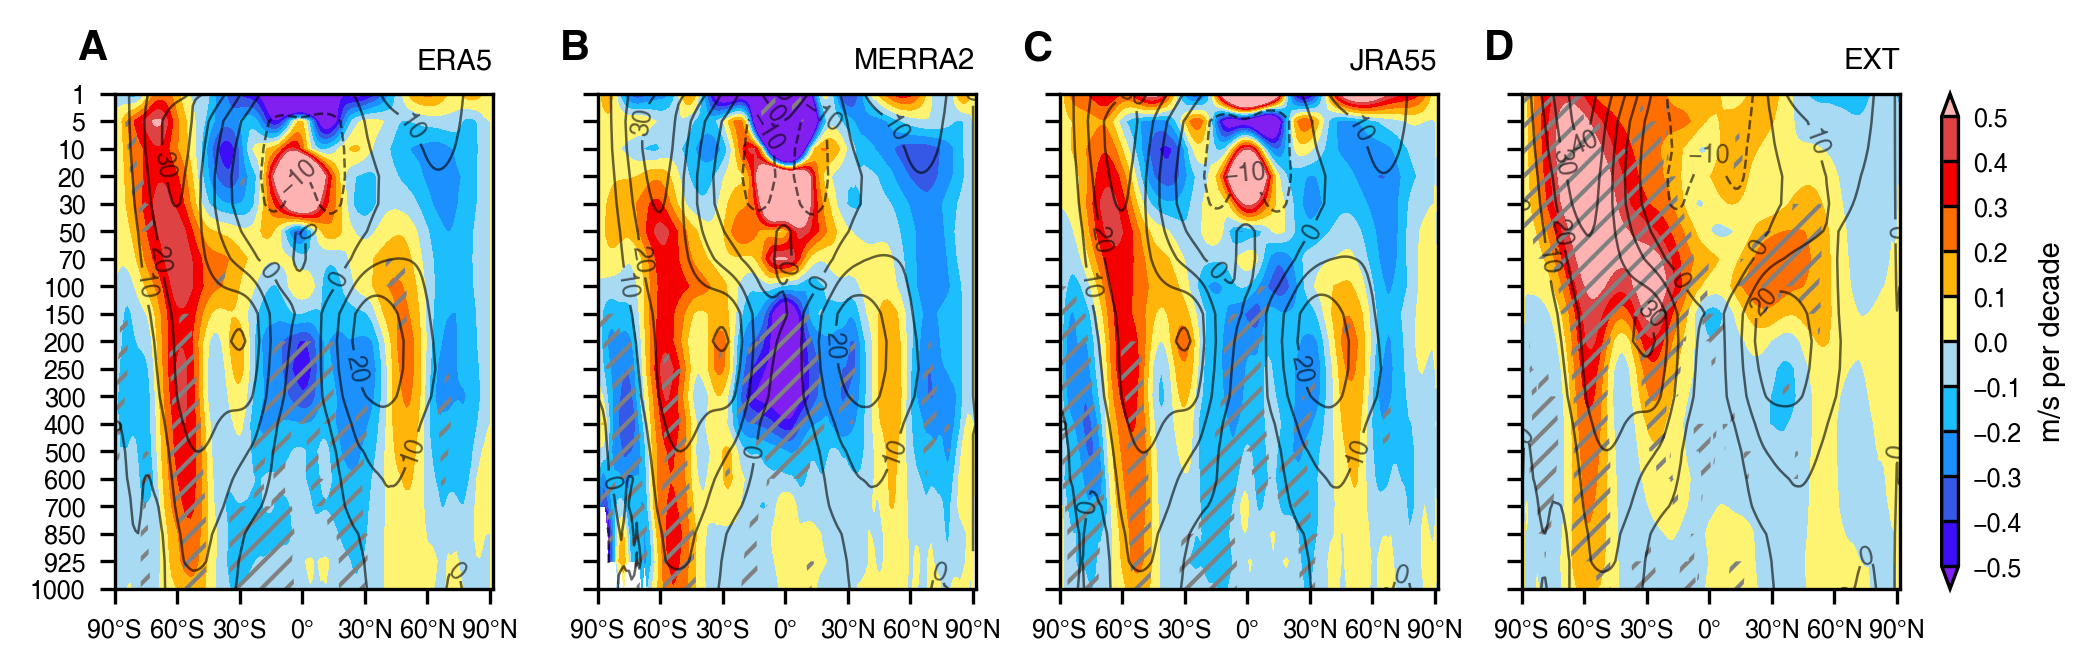

In [16]:
#################绘制不同外强迫作用的bar图#######################
#############################################################

level= ERA5.level
level_label = list(map(int, level.data.tolist()))
era5_lat = ERA5.lat
level_change = np.arange(-.5, .6, 0.1)
level_clim_without20 = [-10,0,10]
sub_add_axes = [[0.05, 0.1, 0.18, 0.75], [0.28, 0.1, 0.18, 0.75],[0.5, 0.1, 0.18, 0.75],[0.72, 0.1, 0.18, 0.75]]
exp = ['ERA5','MERRA2','JRA55','EXT']
labels=['20°-40°N','20°-40°S']
sequence=['A','B','C','D']
fig = plt.figure(figsize=(7, 2.2),dpi=300)
for i in range(4):
    if i<=3:
        ax1 = fig.add_axes(sub_add_axes[i])
        cycle_data, cycle_mon = add_cyclic_point(meri_trend[i], coord=era5_lat)
        cycle_MON, cycle_LEVEL = np.meshgrid(cycle_mon, np.arange(level.shape[0]))

        c1 = ax1.contourf(cycle_MON, cycle_LEVEL, cycle_data * 10, cmap=ccmap, levels=level_change, extend='both')
        cycle_clim, cycle_mon = add_cyclic_point(meri_clim[i], coord=era5_lat)
        c2 = ax1.contour(cycle_MON, cycle_LEVEL, cycle_clim, levels=level_clim_without20, colors='k', alpha=0.6,
                         linewidths=0.6)
        c3 = ax1.contour(cycle_MON, cycle_LEVEL, cycle_clim, levels=[20, 30, 40, 50], colors='k', alpha=0.6,
                         linewidths=0.6)
        ax1.clabel(c3, inline=True, fontsize=6)

        cycle_dot, cycle_mon = add_cyclic_point(meri_significant_points[i], coord=era5_lat)
        significance = np.ma.masked_where(cycle_dot == False, cycle_dot)
        c3 = ax1.contourf(cycle_MON, cycle_LEVEL, significance, colors='none', hatches=['////'])
        '''for j, collection in enumerate(c3.collections):  ############更改打点的颜色
            collection.set_edgecolor('silver')
        for collection in c3.collections:
            collection.set_linewidth(0)'''
        if hasattr(c3, 'collections'):
            collections = c3.collections
        else:
            # 如果 `cc` 本身就是类似集合的对象（旧版本 Matplotlib）
            collections = [c3]  # 包装成列表，使其可迭代
        # 设置 hatch 样式
        for collection in collections:
            collection.set_edgecolor('grey')
            collection.set_linewidth(0)

        ax1.clabel(c2, inline=True, fontsize=6)
        ax1.set_xticks([-90, -60, -30, 0, 30, 60, 90])  # 指定要显示的经纬度
        ax1.xaxis.set_major_formatter(LatitudeFormatter())  # 刻度格式转换为经纬度样式
        if i == 0:
            ax1.yaxis.set_ticks(np.arange(level.shape[0]), level_label)  # 指定要显示的经纬度
        else:
            ax1.yaxis.set_ticks(np.arange(level.shape[0]), [])
        ax1.tick_params(axis='x', labelsize=6)  # 设置x轴刻度数字大小
        ax1.tick_params(axis='y', labelsize=6)  # 设置y轴刻度数字大小
        ax1.text(-0.1, 1.13, sequence[i], transform=ax1.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
        ax1.set_title(exp[i], loc='right', fontsize=7)
bar_ax = fig.add_axes([0.92, 0.1, 0.008, 0.75])
cb = plt.colorbar(c1, cax=bar_ax, orientation='vertical', shrink=0.85, pad=0.05, extend='both')
cb.ax.yaxis.set_major_locator(MultipleLocator(0.2))
cb.set_ticks(level_change)
cb.ax.tick_params(axis='y', which='major', direction='in', labelsize=6)
'''ticks = cb.get_ticks()
cb.set_ticks(ticks)
cb.set_ticklabels([f'{tick:.1f}' for tick in ticks], fontsize=8)'''

cb.set_label(label=r'm/s per decade', fontsize=7)
plt.savefig('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/ScienceStyleFigures/Fig.S1.3obs_all_meri_and_bar_1980-2020_100minus200.png',format='png',dpi=300)
plt.savefig('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/ScienceStyleFigures/Fig.S1.3obs_all_meri_and_bar_1980-2020_100minus200.svg',format='svg',dpi=300)
plt.subplots_adjust(wspace=0.5)
plt.show()